In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler                                     
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score as AUC
from sklearn.feature_selection import RFECV, RFE
from sklearn.preprocessing import StandardScaler 
from sklearn.base import clone
from sklearn import tree
from sklearn.model_selection import ParameterGrid, GridSearchCV
from joblib import Parallel, delayed
from multiprocessing import Pool
from tqdm import tqdm
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from skbio.stats.ordination import pcoa
import umap
from sklearn.metrics import make_scorer
from sklearn import linear_model
import warnings
warnings.filterwarnings("ignore")

# Read data

In [7]:
# read meta data
df_meta = pd.read_csv('../../../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin'] # only for inulin group
df_meta = df_meta[df_meta.Day != 0] # remove day 0

# read SCFA data
df_scfa = pd.read_csv('../../../../../our_data/SCFA.csv', index_col=0)

# read bacterial abundance (asv level)
df_bac = pd.read_csv('../../../../../our_data/16S_absolute_abundance_species.csv', index_col=0).T

# find common samples
common_samples = list(set(df_meta.index).intersection(df_scfa.index).intersection(df_bac.index))
df_meta = df_meta.loc[common_samples]
df_scfa = df_scfa.loc[common_samples]
df_bac = df_bac.loc[common_samples]

# read producer labels
df_tax = pd.read_csv('../../../../../our_data/taxonomy_plus_scfa_producers.csv', index_col=0)

# find producer score for each species


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
df

# Find best parameters

In [11]:
xdata_train = np.asarray(df_bac.values)

for scfa in ['Acetate','Propionate','Butyrate']:  
    ydata_train = np.asarray(df_scfa[scfa])
    
    # make pipeline
    # use lasso for feature selection
    param_grid = {
        'selectfrommodel__estimator__alpha':[10**v for v in [-4,-3,-2,-1,0]], # too large alpha will produce a null model (all features are 0)
        'randomforestregressor__max_features':['auto','sqrt','log2',0.16,0.32,0.64],
        'randomforestregressor__max_depth':[2,4,8,16],
        'randomforestregressor__min_samples_split':[2,4,8,16],
        'randomforestregressor__min_samples_leaf':[1,2,4]
    }

    clf1 = linear_model.Lasso(tol=1e-5,positive=True,random_state=0,max_iter=1000000)
    clf2 = RandomForestRegressor(n_estimators=2000,random_state=0,oob_score=True)
    pipe = make_pipeline(StandardScaler(), SelectFromModel(clf1, threshold=1e-5), clone(clf2))  
    CV = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=2)
    CV.fit(xdata_train, ydata_train)

    print('%s, best score and parameter combination = '%(scfa))
    print(CV.best_score_)    
    print(CV.best_params_)    
    print('\n')

Acetate, best score and parameter combination = 
0.08954787081257469
{'randomforestregressor__max_depth': 16, 'randomforestregressor__max_features': 0.16, 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__min_samples_split': 2, 'selectfrommodel__estimator__alpha': 1}


Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 41.7min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 53.5min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 67.4min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 84.0min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 100.8min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 123.0min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 145.0min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed: 153.7min finished


Propionate, best score and parameter combination = 
0.48581635137161483
{'randomforestregressor__max_depth': 16, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'selectfrommodel__estimator__alpha': 0.1}


Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 40.7min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 53.1min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 67.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 85.8min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 104.1min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 125.8min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 147.7min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed: 156.5min finished


Butyrate, best score and parameter combination = 
0.3772058174489022
{'randomforestregressor__max_depth': 8, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 4, 'selectfrommodel__estimator__alpha': 0.0001}




# Run RFECV

In [55]:
best_alpha = {'Acetate':1.0, 'Propionate':0.1, 'Butyrate':0.0001}

df_selected_features = None
for scfa in ['Acetate','Propionate','Butyrate']:                
    
    # filter out ASVs
    df_bac_tmp = df_bac[set(df_bac.columns).intersection(set(df_tax[df_tax['Is%sProducer'%scfa]==1].index))]
    
    # remove constant predictors
    df_bac_tmp = df_bac_tmp[list(df_bac_tmp.std()[df_bac_tmp.std()>0].index)]
    
    # print
    print('number of predictors = %d'%(len(df_bac_tmp.columns)))
    
    # get data
    xdata = np.asarray(df_bac_tmp.values)
    ydata = np.asarray(df_scfa[scfa])
    
    # make pipeline
    clf = linear_model.Lasso(tol=1e-5,alpha=best_alpha[scfa],positive=True,random_state=0,max_iter=1000000)
    pipe = make_pipeline(StandardScaler(), SelectFromModel(clf, threshold=1e-5), RFE(clf, verbose=2, n_features_to_select=1))
    pipe.fit(xdata, ydata)
    
    # selected features
    selected_features = list(df_bac_tmp.iloc[:,list(np.where(pipe.named_steps['selectfrommodel'].get_support())[0])].columns)
    ordered_selected_features = ['']*len(selected_features)
    for pos_old, pos_new in enumerate(list(pipe.named_steps['rfe'].ranking_)):
        ordered_selected_features[pos_new-1] = selected_features[pos_old]
   
    df_tmp = df_tax.loc[ordered_selected_features]
    df_tmp['SCFA'] = scfa
    if df_selected_features is None:
        df_selected_features = df_tmp
    else:
        df_selected_features = pd.concat([df_selected_features, df_tmp])
        
df_selected_features.head()

number of predictors = 277
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
number of predictors = 161
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 

,Confidence,Kingdom,Phylum,Class,Order,Family,Genus,Species,LowestClassifiedTaxon_Species,LowestClassifiedTaxon_Genus,LowestClassifiedTaxon_Family,LowestClassifiedTaxon_Order,LowestClassifiedTaxon_Class,LowestClassifiedTaxon_Phylum,IsAcetateProducer,IsButyrateProducer,IsPropionateProducer,SCFA
ASV,,,,,,,,,,,,,,,,,,
49da2429319bb8bab3d9139319699d74,0.992503,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lachnospiraceae-NK4A136-group,unclassified,Lachnospiraceae-NK4A136-group,Lachnospiraceae-NK4A136-group,Lachnospiraceae,Lachnospirales,Clostridia,Firmicutes,1.0,0.0,0.0,Acetate
0b438323a296b5f2ce2c8bbe3949ee8d,0.856485,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,acidifaciens,Bacteroides-acidifaciens,Bacteroides,Bacteroidaceae,Bacteroidales,Bacteroidia,Bacteroidota,1.0,0.0,1.0,Acetate
8bee12c45f4dc4dfc7ade55870939c3d,0.999997,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,unclassified,unclassified,Lachnospiraceae,Lachnospiraceae,Lachnospiraceae,Lachnospirales,Clostridia,Firmicutes,1.0,1.0,0.0,Acetate
9e499b818284bc88da1591330270d59d,0.920340,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,uncultured-bacterium,Alistipes,Alistipes,Rikenellaceae,Bacteroidales,Bacteroidia,Bacteroidota,1.0,1.0,1.0,Acetate
19d1ac8febd7ed7dcecb8d12eb4954c1,0.984883,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lachnospiraceae-NK4A136-group,unclassified,Lachnospiraceae-NK4A136-group,Lachnospiraceae-NK4A136-group,Lachnospiraceae,Lachnospirales,Clostridia,Firmicutes,1.0,0.0,0.0,Acetate


In [66]:
df_selected_features_tmp = df_selected_features[['SCFA']]
df_selected_features_tmp['Selected'] = 1
df_selected_features_tmp = pd.pivot_table(df_selected_features_tmp.reset_index(), index='ASV', values='Selected', columns='SCFA').fillna(0)
df_selected_features_tmp

SCFA,Acetate,Butyrate,Propionate
ASV,,,
0b438323a296b5f2ce2c8bbe3949ee8d,1.0,0.0,1.0
19d1ac8febd7ed7dcecb8d12eb4954c1,1.0,0.0,0.0
23e70e83a18492295f0ab774f36bd428,0.0,1.0,0.0
275a909b71518ce743cea6406287671e,1.0,0.0,0.0
2fa437bdcaad5b499ea48648d66765ae,0.0,1.0,0.0
352e01b25b13ceaef79c9b32cf7962eb,0.0,0.0,1.0
35349e11a88fa9340b766e859e9b7122,0.0,0.0,1.0
44bd1efc8d03b8e1153d643564b15e9c,1.0,0.0,0.0
46dc0fc28dac8a057736ae7f3217673c,0.0,1.0,1.0


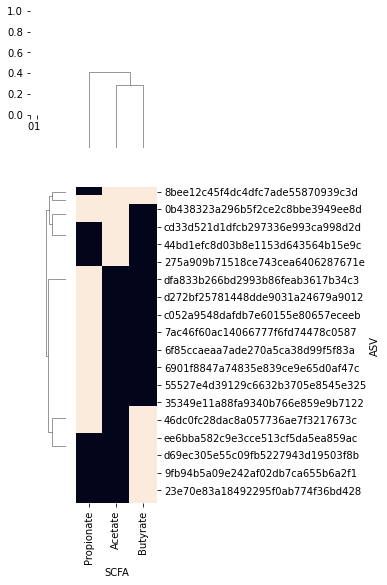

In [71]:
_ = sns.clustermap(df_selected_features_tmp, cbar=False, figsize=(2,8))

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("selected_producers.svg", format="svg")